# Tarea Principal
- Se pide implementar comparar el rendimiento de diferentes herramientas de
AutoML para la clasificación de datos tabulares.

# Comparacion

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 48 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_migue8gl_wc5wup
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.859 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

===== XGBoost =====
Tiempo: 0.06 segundos

----- XGBoost -----
Accuracy: 0.9815
F1 Score: 0.9815

===== TabPFN =====
Tiempo: 1.06 segundos

----- TabPFN -----
Accuracy: 1.0000
F1 Score: 1.0000

===== H2O AutoML =====
AutoML progress: |
22:24:17.259: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 124.0.

███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Tiempo: 306.62 segundos

----- H2O AutoML -----
Accuracy: 1.0000
F1 Score: 1.0000

Modelo ganador de H2O AutoML:
Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20250330_222416_model_2


Status of Neu

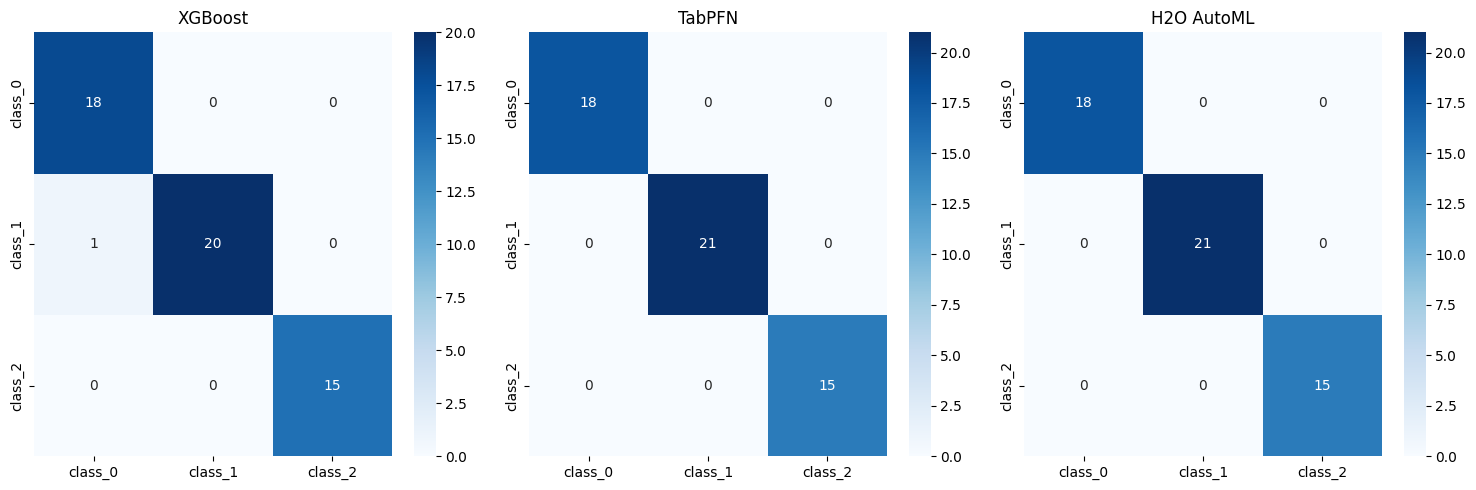

In [8]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import xgboost as xgb
from tabpfn import TabPFNClassifier
import h2o
from h2o.automl import H2OAutoML
import random
import warnings

warnings.filterwarnings("ignore")


def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)


def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"\n----- {model_name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, f1, cm


def plot_confusion_matrices(confusion_matrices, class_names):
    n_models = len(confusion_matrices)
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 5, 5))
    if n_models == 1:
        axes = [axes]
    for i, (model_name, cm) in enumerate(confusion_matrices.items()):
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[i],
        )
        axes[i].set_title(model_name)
    plt.tight_layout()
    return fig


h2o.init()
seed = 140421
set_seed(seed)

data = load_wine()
X, y = data.data, data.target
feature_names = data.feature_names
class_names = data.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=seed
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

skfcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
fold_column = np.zeros(len(X_train_scaled), dtype=int)
for fold_number, (train_idx, val_idx) in enumerate(
    skfcv.split(X_train_scaled, y_train)
):
    fold_column[val_idx] = fold_number

train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
train_df["target"] = y_train
train_df["fold"] = fold_column

test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
test_df["target"] = y_test

train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

train_h2o["target"] = train_h2o["target"].asfactor()
test_h2o["target"] = test_h2o["target"].asfactor()

results = {}
training_times = {}
confusion_matrices = {}

# 1. XGBoost
print("\n===== XGBoost =====")
start_time = time.time()
xgb_model = xgb.XGBClassifier(random_state=seed)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_time = time.time() - start_time
training_times["XGBoost"] = xgb_time
print(f"Tiempo: {xgb_time:.2f} segundos")
accuracy_xgb, f1_xgb, cm_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")
results["XGBoost"] = {"accuracy": accuracy_xgb, "f1": f1_xgb}
confusion_matrices["XGBoost"] = cm_xgb

# 2. TabPFN
print("\n===== TabPFN =====")
start_time = time.time()
if X_train_scaled.shape[0] <= 1000 and X_train_scaled.shape[1] <= 100:
    # Probando con los parámetros correctos para TabPFN
    tabpfn_model = TabPFNClassifier(n_estimators=32)
    tabpfn_model.fit(X_train_scaled, y_train)
    y_pred_tabpfn = tabpfn_model.predict(X_test_scaled)
    tabpfn_time = time.time() - start_time
    training_times["TabPFN"] = tabpfn_time
    print(f"Tiempo: {tabpfn_time:.2f} segundos")
    accuracy_tabpfn, f1_tabpfn, cm_tabpfn = evaluate_model(
        y_test, y_pred_tabpfn, "TabPFN"
    )
    results["TabPFN"] = {"accuracy": accuracy_tabpfn, "f1": f1_tabpfn}
    confusion_matrices["TabPFN"] = cm_tabpfn
else:
    print("TabPFN no se puede entrenar: dataset demasiado grande")

# 3. H2O AutoML
print("\n===== H2O AutoML =====")
start_time = time.time()
predictors = feature_names
target = "target"

aml = H2OAutoML(max_runtime_secs=300, seed=seed, exclude_algos=["XGBoost"])

aml.train(x=predictors, y=target, training_frame=train_h2o)
preds_h2o = aml.predict(test_h2o)
y_pred_h2o = preds_h2o["predict"].as_data_frame().values.ravel()
h2o_time = time.time() - start_time
training_times["H2O AutoML"] = h2o_time
print(f"Tiempo: {h2o_time:.2f} segundos")
accuracy_h2o, f1_h2o, cm_h2o = evaluate_model(y_test, y_pred_h2o, "H2O AutoML")
results["H2O AutoML"] = {"accuracy": accuracy_h2o, "f1": f1_h2o}
confusion_matrices["H2O AutoML"] = cm_h2o

print("\nModelo ganador de H2O AutoML:")
print(aml.leader)

comparison_df = pd.DataFrame(
    {
        "Modelo": list(results.keys()),
        "Accuracy": [results[model]["accuracy"] for model in results],
        "F1 Score": [results[model]["f1"] for model in results],
        "Tiempo (s)": [training_times[model] for model in results],
    }
)
print("\n----- Comparación de Modelos -----")
print(comparison_df.to_string(index=False))

plot_confusion_matrices(confusion_matrices, class_names)
h2o.shutdown(prompt=False)
print("\nComparación completada.")

# Análisis
- En términos de rendimiento y eficiencia, TabPFN destaca como la opción más equilibrada:
    - Consigue una precisión perfecta (1.0), al igual que H2O AutoML.
    - Es casi 300 veces más rápido que H2O AutoML.
    - Solo necesita aproximadamente 1 segundo para entrenar el modelo.
    - Supera a XGBoost en precisión, con un tiempo de entrenamiento razonable.

- Por su parte, XGBoost se presenta como una opción muy eficiente en cuanto a tiempo:
    - El tiempo de entrenamiento más rápido (0.06 segundos).
    - Obtiene un rendimiento excelente (0.9815), aunque ligeramente inferior al de TabPFN y H2O AutoML.

- En cuanto a H2O AutoML, aunque logra la misma precisión perfecta (1.0), su rendimiento tiene algunas limitaciones:
    - El tiempo de entrenamiento es considerablemente alto (306 segundos) para una mejora marginal sobre XGBoost, aunque el parámetro es ajusable.
    - Utiliza una red neuronal profunda como mejor modelo, que puede ser más compleja de implementar y mantener.

- La simplicidad y la velocidad de TabPFN lo hacen mucho más eficiente en este caso en comparación con las soluciones AutoML tradicionales:
    - Eficiencia computacional: TabPFN alcanza resultados perfectos en solo 1 segundo, mientras que H2O AutoML necesita más de 5 minutos para obtener el mismo rendimiento.
    - Simplicidad: El enfoque basado en Prior-Data Fitted Networks de TabPFN requiere poco ajuste de hiperparámetros y entrega resultados sobresalientes de inmediato.